In [ ]:
import numpy as np
import pandas as pd
import pickle

In [ ]:
#Import necessary packages
import rpy2.robjects as robjects
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
#Must be activated
pandas2ri.activate()
paramlink2=importr('paramlink2')
pedprobr=importr('pedprobr')
pedtools = importr('pedtools')

In [ ]:
import time
from concurrent.futures import ProcessPoolExecutor

## Functions to deal with haplotypes

In [ ]:
def get_allele(s):
    a = s[1] if s[0].isupper() else s[0]
    return 0 if a=='?' else int(a)

In [ ]:
def name_haps(snps):
    name = []
    for i in snps:
        name += [i+'_A0',i+'_A1']
    return name

In [ ]:
def get_fam_hap(haps,name=None):
    new_haps,new_iid = [],[]
    iid = haps[:,1]
    haps = haps[:,2:]
    for i in range(0,haps.shape[0],2):
        new_iid.append(iid[i])
        hap_a01 = []
        for a0,a1 in zip(haps[i],haps[i+1]):
            hap_a01 += [get_allele(a0),get_allele(a1)]
        new_haps.append(hap_a01)
    new_haps = pd.DataFrame(new_haps)
    new_haps.index = new_iid
    if name is not None:
        new_haps.columns = name
    return new_haps

## All genes from haps to peds

In [ ]:
def format_haps_bunch(dhaps,fam):
    gene_variants = {}
    gene_haps = {}
    for g in dhaps.keys():
        haps = dhaps[g]['predata']
        for f in haps.keys():
            if f not in gene_variants.keys():
                gene_variants[f] = {'genes':[],'variants':[],'freqs':[],'uniq':[]}
                gene_haps[f] = get_fam_hap(haps[f][2],name_haps(haps[f][0]))
            else:
                gene_haps[f] = pd.concat([gene_haps[f],get_fam_hap(haps[f][2],name_haps(haps[f][0]))],axis=1)
            gene_variants[f]['genes'] += [g]*len(haps[f][0])
            gene_variants[f]['variants'] += list(haps[f][0])
            gene_variants[f]['freqs'] += list(haps[f][1])
    for i,j in gene_variants.items():
        redup_idx = ~gene_haps[i].columns.duplicated()
        gene_haps[i] = pd.concat([fam[i],gene_haps[i].iloc[:,redup_idx]],axis=1)
        j['uniq'] = list(redup_idx[range(0,len(redup_idx),2)])
        gene_variants[i] = pd.DataFrame(j)
    return gene_variants,gene_haps

In [ ]:
def calculate_ped_lod(ped,rho=0,model = "AD",chrom = "AUTOSOMAL",penetrances = [0.01,0.9,0.9],dfreq=0.001):
    aff=ped.iloc[:,5]
    mped = pedtools.as_ped(ped.drop(ped.columns[5], axis=1),famid_col = 1,id_col = 2,fid_col = 3,mid_col = 4,sex_col = 5)
    modAD = paramlink2.diseaseModel(model,chrom,pd.Series(penetrances),dfreq)
    res = paramlink2.lod(mped, aff = aff, model = modAD,rho=rho)
    try:
        res = pd.DataFrame(res)[['MARKER','LOD']]
    except:
        res = pd.DataFrame([[ped.columns[6],res[0]]],columns=['MARKER','LOD'])
    return res

In [ ]:
def sum_variant_lods(lods):
    variants = {}
    for lod in lods:
        for m,l in zip(lod['MARKER'],lod['LOD']):
            if m in variants.keys():
                variants[m] += l
            else:
                variants[m] = l
    var_lst = []
    for var,lod in variants.items():
        snp = var[:-3]
        var_lst.append(snp.split(':')+[snp,lod])
    variants=pd.DataFrame(var_lst,columns=['CHR','POS','A0','A1','SNP','LOD'])
    variants.POS = variants.POS.astype(int)
    variants.sort_values('POS')
    return variants

In [ ]:
def parallel_lods(haps):
    start = time.perf_counter()
    with ProcessPoolExecutor(max_workers = 10) as executor:
        results = executor.map(calculate_ped_lod,haps)
    print(time.perf_counter()-start)
    return results

### Read fam

In [ ]:
fam17 = pd.read_csv('../data/new_trim_ped_famless17_no:xx.fam',delim_whitespace=True,header=None,names=['fid','iid','fathid','mothid','sex','ad'])

In [ ]:
fam17.ad[fam17.ad==-9]=0

/tmp/2293088.1.high_mem.q/ipykernel_15496/1308232463.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  fam17.ad[fam17.ad==-9]=0


In [ ]:
fam17.index = list(fam17.iid)

In [ ]:
fam17.ad.value_counts()

2    1900
0    1042
1     957
Name: ad, dtype: int64

In [ ]:
fam17_d = {}
for i in fam17.fid.unique():
    fam17_d[i] = fam17[fam17.fid==i]

## Read haplotypes

In [ ]:
for i in range(0,68):
    print('../data/wg20220311/chr19test/CACHE/chr19test'+str(i))
    run_gene_lods('../data/wg20220311/chr19test/CACHE/chr19test'+str(i),fam17_d)

../data/wg20220311/chr19test/CACHE/chr19test0
246.69868233427405
../data/wg20220311/chr19test/CACHE/chr19test1
226.53525406122208
../data/wg20220311/chr19test/CACHE/chr19test2
127.57361337170005
../data/wg20220311/chr19test/CACHE/chr19test3
165.55025619268417
../data/wg20220311/chr19test/CACHE/chr19test4
734.3437443822622
../data/wg20220311/chr19test/CACHE/chr19test5
371.68568187206984
../data/wg20220311/chr19test/CACHE/chr19test6
382.52671583741903
../data/wg20220311/chr19test/CACHE/chr19test7
295.4932692013681
../data/wg20220311/chr19test/CACHE/chr19test8
176.93624715134501
../data/wg20220311/chr19test/CACHE/chr19test9
449.8376136906445
../data/wg20220311/chr19test/CACHE/chr19test10
179.24991587921977
../data/wg20220311/chr19test/CACHE/chr19test11
250.4802982583642
../data/wg20220311/chr19test/CACHE/chr19test12
209.12226210907102
../data/wg20220311/chr19test/CACHE/chr19test13
167.27087911218405
../data/wg20220311/chr19test/CACHE/chr19test14
341.3407261483371
../data/wg20220311/chr19t

In [ ]:
def run_gene_lods(file,fam,cutoff=None):
    with open(file+'.pickle', 'rb') as handle:
        genes = pickle.load(handle)
    gene_variants,gene_fam_haps = format_haps_bunch(genes,fam)
    if cutoff is not None:
        for f,variants in gene_variants.items():
            gene_fam_haps[f]=gene_fam_haps[f].loc[:,[True]*6+list(np.repeat((variants.freqs>cutoff)[variants.uniq],2))]
    res = parallel_lods(gene_fam_haps.values())
    smy_res = sum_variant_lods(res)
    with open(file+'cutoff'+str(cutoff)+'.result','wb') as handle:
        pickle.dump(smy_res, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
run_gene_lods('../data/wg20220311/chr19test/CACHE/chr19test43',fam17_d,cutoff=0.05)

134.5462392270565


In [ ]:
with open('../data/wg20220311/chr19test/CACHE/chr19test43.pickle', 'rb') as handle:
    genes = pickle.load(handle)
gene_variants,gene_fam_haps = format_haps_bunch(genes,fam17_d)

In [ ]:
gene_variants['1007']

,genes,variants,freqs,uniq
0,LOC100379224,chr19:44105534:T:TTTTTA,0.2291,True
1,LOC100379224,chr19:44105571:T:A,0.2283,True
2,LOC100379224,chr19:44105679:C:T,0.0131,True
3,LOC100379224,chr19:44105693:C:G,0.4481,True
4,LOC100379224,chr19:44105746:C:G,0.0010,True
...,...,...,...,...
1745,APOC1,chr19:44918393:G:A,0.0228,True
1746,APOC1,chr19:44918487:G:T,0.3027,True
1747,APOC1,chr19:44918620:A:G,0.4856,True
1748,APOC1,chr19:44918715:AG:A,0.2989,True


In [ ]:
gene_fam_haps['1007'].loc[:,[True]*6+list(np.repeat(gene_variants['1007']['freqs']>0.05,2))]

,fid,iid,fathid,mothid,sex,ad,chr19:44105534:T:TTTTTA_A0,chr19:44105534:T:TTTTTA_A1,chr19:44105571:T:A_A0,chr19:44105571:T:A_A1,...,chr19:44917997:G:A_A0,chr19:44917997:G:A_A1,chr19:44918487:G:T_A0,chr19:44918487:G:T_A1,chr19:44918620:A:G_A0,chr19:44918620:A:G_A1,chr19:44918715:AG:A_A0,chr19:44918715:AG:A_A1,chr19:44918903:C:G_A0,chr19:44918903:C:G_A1
1007_39,1007,1007_39,1007_40,1007_4,1,1,1,1,1,1,...,1,1,1,2,2,1,1,2,1,1
1007_99,1007,1007_99,1007_1,1007_2,2,2,2,2,2,2,...,1,1,1,2,1,1,1,2,2,1
1007_3,1007,1007_3,1007_1,1007_2,1,2,1,2,1,2,...,1,1,1,2,2,1,1,2,1,1
1007_5,1007,1007_5,1007_1,1007_2,2,2,1,2,1,2,...,1,2,1,1,2,1,1,1,1,2
1007_40,1007,1007_40,0,0,1,0,1,0,1,0,...,1,0,2,0,1,0,2,0,1,0
1007_6,1007,1007_6,1007_1,1007_2,2,2,1,2,1,2,...,1,2,1,1,2,1,1,1,1,2
1007_1,1007,1007_1,0,0,1,0,2,2,2,2,...,2,1,1,2,1,1,1,2,2,1
1007_2,1007,1007_2,0,0,2,0,1,2,1,2,...,1,1,1,1,2,1,1,1,1,2
1007_4,1007,1007_4,1007_1,1007_2,2,0,1,2,1,2,...,1,2,1,1,2,1,1,1,1,2


In [ ]:
smy_ress=[]
for i in range(0,68):
    with open('../data/wg20220311/chr19test/CACHE/chr19test'+str(i)+'.result', 'rb') as handle:
        smy_ress.append(pickle.load(handle))

In [ ]:
smy_ress = pd.concat(smy_ress)

In [ ]:
smy_ress = smy_ress.reset_index(drop=True)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
min(smy_ress.LOD)

-245.93826248735394

In [ ]:
sum(smy_ress.LOD.isna())

0

In [ ]:
tmp = smy_ress.LOD

<AxesSubplot:>

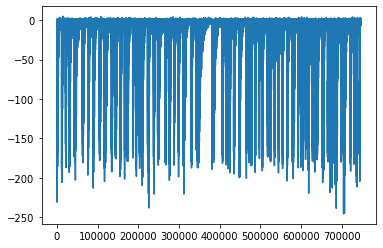

In [ ]:
tmp.plot()

In [ ]:
tmp[tmp<0]=0

/tmp/2293088.1.high_mem.q/ipykernel_15496/2345529312.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tmp[tmp<0]=0


<AxesSubplot:>

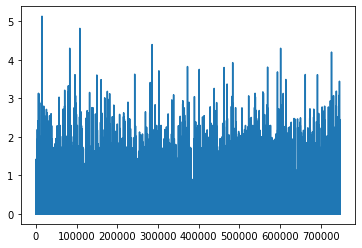

In [ ]:
tmp.plot()

In [ ]:
with open('../data/wg20220311/chr19test/CACHE/common_variants.pickle','rb') as handle:
    com_vars = pickle.load(handle)

In [ ]:
smy_ress_com = smy_ress[smy_ress.SNP.isin(com_vars)]

<AxesSubplot:>

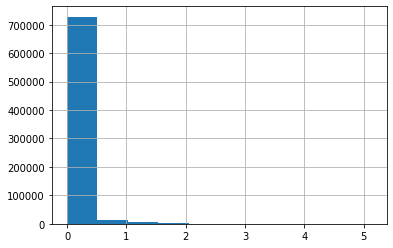

In [ ]:
smy_ress.LOD.hist()

<AxesSubplot:>

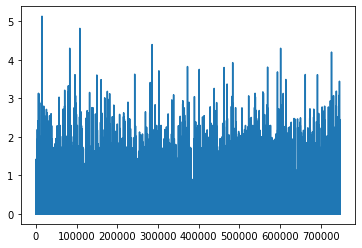

In [ ]:
smy_ress.LOD.plot()

<AxesSubplot:>

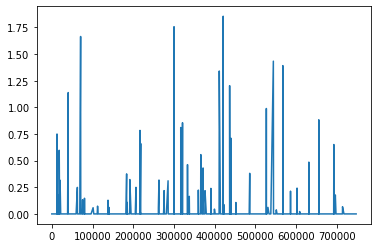

In [ ]:
smy_ress_com.LOD.plot()

In [ ]:
(smy_ress_com.POS>44905795) & (smy_ress_com.POS<44909395)

0         False
2         False
3         False
4         False
6         False
          ...  
747080    False
747081    False
747094    False
747096    False
747166    False
Name: POS, Length: 126370, dtype: bool

In [ ]:
(smy_ress_com.POS>44905795) & (smy_ress_com.POS<44909395)

0         False
2         False
3         False
4         False
6         False
          ...  
747080    False
747081    False
747094    False
747096    False
747166    False
Name: POS, Length: 126370, dtype: bool

In [ ]:
col = pd.Series(['blue']*len(smy_ress_com.LOD))
col[list((smy_ress_com.POS>4905795) & (smy_ress_com.POS<44909395))]='red'

In [ ]:
sum((smy_ress_com.POS>44905795) & (smy_ress_com.POS<44909395))

5

<AxesSubplot:>

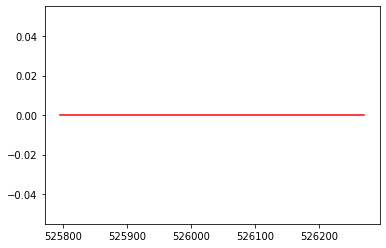

In [ ]:
#smy_ress_com.LOD.plot(color=list(col))
smy_ress_com[(smy_ress_com.POS>44905795) & (smy_ress_com.POS<44909395)].LOD.plot(color='red')

<AxesSubplot:>

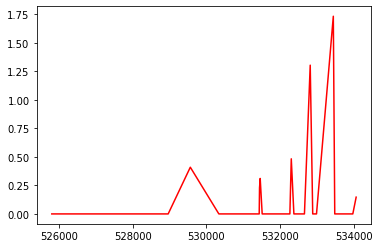

In [ ]:
#smy_ress_com.LOD.plot(color=list(col))
smy_ress[(smy_ress.POS>44905795) & (smy_ress.POS<44909395)].LOD.plot(color='red')

In [ ]:
tmp = apoe_haps[166]

In [ ]:
tmpped = pedtools.as_ped(tmp.loc[:,tmp.columns!='ad'],famid_col = 1,id_col = 2,fid_col = 3,mid_col = 4,sex_col = 5)

In [ ]:
modAD = paramlink2.diseaseModel(model = "AD",chrom = "AUTOSOMAL",penetrances = pd.Series([0.01,0.9,0.9]),dfreq=0.001)

In [ ]:
res = paramlink2.lod(tmpped, aff = tmp.ad, model = modAD,rho=0)

In [ ]:
a = pd.Series(res)

In [ ]:
a.index = list(res.MARKER)

In [ ]:
a

V1-44905910_A0     0.394206
V18-44906745_A0    1.209667
V25-44907187_A0   -0.018740
V49-44908684_A0    1.382766
V52-44908822_A0    0.000000
Name: LOD, dtype: float64

In [ ]:
tmpped.typeof()

TypeError: 'RTYPES' object is not callable

In [ ]:
pd.DataFrame(res)[['MARKER','LOD']]

,MARKER,LOD
1,V1-44905910_A0,0.394206
2,V18-44906745_A0,1.209667
3,V25-44907187_A0,-0.018740
4,V49-44908684_A0,1.382766
5,V52-44908822_A0,0.000000


In [ ]:
modAD

chrom,[RTYPES.STRSXP]
penetrances,[RTYPES.REALSXP]
dfreq,[RTYPES.REALSXP]


In [ ]:
?time_series

Signature:   time_series(*args, **kwargs)
Type:        SignatureTranslatedFunction
String form:
function (data = NA, start = 1, end = numeric(), frequency = 1,
           deltat = 1, ts.eps = getOpti <...> ttr(data, "class") <- class
           data
           }
           <bytecode: 0x55899c43bdd0>
           <environment: namespace:stats>
           
File:        ~/miniconda3/envs/rpy2/lib/python3.10/site-packages/rpy2/robjects/functions.py
Docstring:  
Python representation of an R function, where
the names in named argument are translated to valid
argument names in Python. 


In [ ]:
import pandas as pd

In [ ]:
#converting the training data into an R time series object
r_times_series_data=time_series(df["Actuals"].values,frequency=12)

NameError: name 'df' is not defined

In [ ]:
#Import the SignatureTranslatedAnonymousPackage 
from rpy2.robjects.packages import STAP
#Read the file with the R code snippet
with open('mlink.r', 'r') as f:
    string = f.read()
#Parse using STAP
mlink_in_python= STAP(string, "mlink")

In [ ]:
?mlink_in_python

Type:            SignatureTranslatedAnonymousPackage
String form:     rpy2.robjects.packages.Package as a <module 'mlink'>
File:            ~/miniconda3/envs/rpy2/lib/python3.10/site-packages/rpy2/robjects/packages.py
Docstring:       <no docstring>
Class docstring:
R package in which the R functions had their signatures
'translated' (that this the named parameters were made to
to conform Python's rules for vaiable names).
Init docstring: 
Create a Python module-like object from an R environment,
using the specified translation if defined.

- env: R environment
- name: package name
- translation: `dict` with R names as keys and corresponding Python
               names as values
- exported_names: `set` of names/symbols to expose to instance users
- on_conflict: 'fail' or 'warn' (default: 'fail')
- version: version string for the package
- symbol_r2python: function to convert R symbols into Python symbols.
                   The default translate `.` into `_`.
- symbol_resolve: function